<a href="https://colab.research.google.com/github/asutoshp10/GAN/blob/main/Pix_to_pix_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [2]:
!kaggle datasets download -d vikramtiwari/pix2pix-dataset

Dataset URL: https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset
License(s): unknown
100% 2.39G/2.40G [00:21<00:00, 67.4MB/s]
100% 2.40G/2.40G [00:21<00:00, 120MB/s] 


In [3]:
import zipfile
zip_ref=zipfile.ZipFile(r'/content/pix2pix-dataset.zip','r')
zip_ref.extractall(r'/content')
zip_ref.close()

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from keras import Model,Input,Sequential
from keras.layers import *
import imghdr

In [5]:
data_dir=r'/content/maps/maps'
train_dir='/content/maps/maps/train'
test_dir='/content/maps/maps/val'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
# satelite_dir=r'/content/maps/satellite'
# default_dir=r'/content/maps/default'
# os.makedirs(satelite_dir,exist_ok=True)
# os.makedirs(default_dir,exist_ok=True)

In [ ]:
# x1,x2=[],[]
# v1,v2=[],[]
# for i in os.listdir(data_dir):
#   print(i)
#   for j in os.listdir(os.path.join(data_dir,i)):
#     img_path=os.path.join(data_dir,i,j)
#     a=imghdr.what(img_path)
#     if a not in image_exts:
#       os.remove(img_path)
#       print(f'{j} has been removed')
#     a=cv2.imread(img_path)
#     a=cv2.resize(a,(256,256))
#     a=(a-127.5)/127.5
#     if j=='train':
#       x1.append(a[:,:600,:])
#       x2.append(a[:,-600:,:])
#     else:
#       v1.append(a[:,:600,:])
#       v2.append(a[:,-600:,:])

In [6]:
import random

In [31]:
def dataset_(batch_size):
  x_tr=tf.keras.preprocessing.image_dataset_from_directory(train_dir,labels=None,image_size=(256,256*2),batch_size=batch_size)
  x_val=tf.keras.preprocessing.image_dataset_from_directory(test_dir,labels=None,image_size=(256,256*2),batch_size=batch_size)
  a=random.choice([x_tr,x_val])
  return a

In [8]:
# x_tr=tf.keras.preprocessing.image_dataset_from_directory(train_dir,labels=None,image_size=(256,256*2),batch_size=1)
# x_val=tf.keras.preprocessing.image_dataset_from_directory(test_dir,labels=None,image_size=(256,256*2),batch_size=1)

In [9]:
# X=next(x_tr.as_numpy_iterator())
# X1=X[:,:,:256,:]
# X2=X[:,:,256:,:]

In [10]:
# def crop_image(image):
#     cropped_image = image[:, :256, :]
#     nor=(cropped_image-127.5)/127.5
#     return nor

# def crop2(image):
#     cropped_image = image[:, -256:, :]
#     nor=(cropped_image-127.5)/127.5
#     return nor
# x1=x_tr.map(crop_image, num_parallel_calls=tf.data.AUTOTUNE)
# x2=x_tr.map(crop2, num_parallel_calls=tf.data.AUTOTUNE)

In [1]:
def generate_real_sample(dataset,batch_size,patch_size):
  y=np.ones((batch_size,patch_size,patch_size,1))
  x=next(dataset.as_numpy_iterator())
  x1=(x[:,:,:256,:]-127.5)/127.5
  x2=(x[:,:,256:,:]-127.5)/127.5
  return [x1,x2],y

In [2]:
def discriminator(input_shape=(256,256,3)):
  init=tf.keras.initializers.RandomNormal(stddev=0.02)
  img=Input(input_shape)
  img_target=Input(input_shape)
  x=concatenate([img,img_target])

  x=Conv2D(64,kernel_size=4,strides=2,padding='same',kernel_initializer=init)(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2D(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init)(x)
  x=BatchNormalization()(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2D(256,kernel_size=4,strides=2,padding='same',kernel_initializer=init)(x)
  x=BatchNormalization()(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2D(512,kernel_size=4,strides=1,padding='same',kernel_initializer=init)(x)
  x=BatchNormalization()(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2D(512,kernel_size=4,strides=1,padding='same',kernel_initializer=init)(x)
  x=BatchNormalization()(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2D(1,(4,4),padding='same',kernel_initializer=init,activation='sigmoid')(x)
  model=Model([img,img_target],x)
  adam=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
  return model

In [13]:
def convolution(input_layer,shape,bn=True,act=True,dropout=0):
  init=tf.keras.initializers.RandomNormal(stddev=0.02)
  conv=Conv2D(shape,(3,3),padding='same',kernel_initializer=init)(input_layer)
  if bn:
    conv=BatchNormalization()(conv)
  if act:
    conv=LeakyReLU(alpha=0.2)(conv)
  if dropout!=0:
    conv=Dropout(dropout)(conv)
  return conv

In [14]:
def encoder(input_layer,shape,dropout,downsample=True):
  conv=convolution(input_layer,shape,dropout=dropout[0])
  conv=convolution(conv,shape,dropout=dropout[1])
  if downsample==True:
    pool=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv)
  else:
    pool=conv
  return pool,conv

In [15]:
def decoder(input_layer,skip_layer,shape,dropout):
  conv=Conv2DTranspose(shape,kernel_size=(4,4),strides=(2,2),padding='same')(input_layer)
  conv=Concatenate()([conv,skip_layer])
  conv=convolution(conv,shape,dropout=dropout[0])
  conv=convolution(conv,shape,dropout[1])
  return conv

In [16]:
def generator(input_shape=(256,256,3)):
  input=Input(input_shape)

  e1_pool,e1_conv=encoder(input,16,dropout=[0.1,0])
  e2_pool,e2_conv=encoder(e1_pool,32,dropout=[0.1,0])
  e3_pool,e3_conv=encoder(e2_pool,64,dropout=[0.2,0])
  e4_pool,e4_conv=encoder(e3_pool,128,dropout=[0.2,0])
  e5_pool,e5_conv=encoder(e4_pool,256,dropout=[0.3,0])
  s_pool,s_conv=encoder(e5_pool,512,dropout=[0.3,0],downsample=False)
  d1=decoder(s_conv,e5_conv,256,dropout=[0.3,0])
  d2=decoder(d1,e4_conv,128,dropout=[0.2,0])
  d3=decoder(d2,e3_conv,64,dropout=[0.2,0])
  d4=decoder(d3,e2_conv,32,dropout=[0.1,0])
  d5=decoder(d4,e1_conv,16,dropout=[0.1,0])
  output=Conv2D(3,(3,3),padding='same',activation='tanh',kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))(d5)

  model=Model(input,output)
  return model

In [3]:
def generate_fake_sample(g_model,batch_size,patch_size):
  dataset=dataset_(batch_size)
  x=next(dataset.as_numpy_iterator())
  x1=(x[:,:,:256,:]-127.5)/127.5
  x2=g_model.predict(x1)
  y=np.zeros((batch_size,patch_size,patch_size,1))
  return [x1,x2],y

In [18]:
def gan(g_model,d_model,input_shape):
  d_model.trainable=False
  input=Input(input_shape)
  g_output=g_model(input)
  d_output=d_model([g_output,input])
  model=Model(input,[d_output,g_output])

  adam=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss=['binary_crossentropy','mae'],optimizer=adam,loss_weights=[1,100])
  return model

In [20]:
# next(x1.as_numpy_iterator()).shape

In [35]:
def train(g_model,d_model,gan_model,batch_size=2,epochs=100):
  half=int(batch_size/2)
  n_patch = d_model.output_shape[1]
  for i in range(epochs):
    dataset=dataset_(half)
    for j in range(69*16):
      x_real,y_real=generate_real_sample(dataset,half)
      d1_loss,d1_acc=d_model.train_on_batch(x_real,y_real,n_patch)
      x_fake,y_fake=generate_fake_sample(g_model,dataset,half,n_patch)
      d2_loss,d2_acc=d_model.train_on_batch(x_fake,y_fake)

      y_gan=np.ones((half,1))
      g_loss,_,g_acc=gan_model.train_on_batch(x_real[0],[y_gan,x_real[1]])
      print(f'epoch:{i} // {j} // d_loss: real-{d1_loss}  fake-{d2_loss} // g_loss:{g_loss}' )

    if i%10==0:
      generate_plot(g_model,i,n_patch)

In [30]:
os.makedirs('/content/model',exist_ok=True)
os.makedirs('/content/plot',exist_ok=True)

In [37]:
def generate_plot(g_model,epoch_no,n_patch):
  dataset=dataset_(16)
  x_real,y_real=generate_real_sample(dataset,16,n_patch)
  y_pred=g_model.predict(x_real[0])
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(y_pred[i])
  g_model.save(f'/content/model/model_{epoch_no}.h5')
  plt.savefig(f'/content/plot/generated_plot_{epoch_no}.png')
  plt.show()
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(x_real[1][i])
  plt.savefig(f'/content/plot/target_plot_{epoch_no}.png')
  plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
1/1 [==============================] - 0s 22ms/step
epoch:0 // 271 // d_loss: real-115.24581909179688  fake-0.0 // g_loss:1145.0003662109375
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
1/1 [==============================] - 0s 21ms/step
epoch:0 // 272 // d_loss: real-1.6235556956056005e-16  fake-0.0 // g_loss:1046.7413330078125
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
1/1 [==============================] - 0s 21ms/step
epoch:0 // 273 // d_loss: real-0.0  fake-0.0 // g_loss:914.7171020507812
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
Found 1096 files belonging to 1 classes.
Found

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


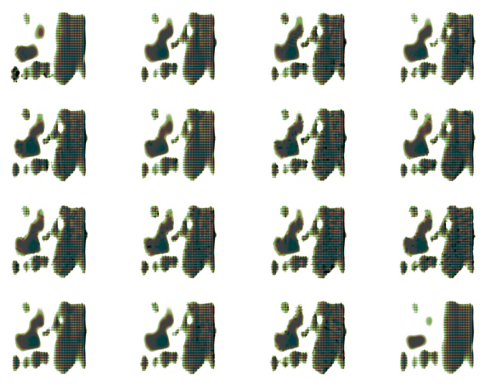

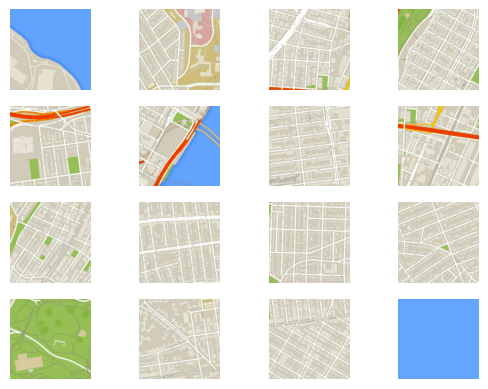

Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
1/1 [==============================] - 0s 26ms/step
epoch:1 // 0 // d_loss: real-0.0  fake-0.0 // g_loss:112.70474243164062
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
1/1 [==============================] - 0s 22ms/step
epoch:1 // 1 // d_loss: real-0.0  fake-0.0 // g_loss:99.19239807128906
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
1/1 [==============================] - 0s 24ms/step
epoch:1 // 2 // d_loss: real-6.358280238516097e-38  fake-0.0 // g_loss:81.14630889892578
Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
Found 1096 files belonging to 1 classe

In [ ]:
g_model=generator()
d_model=discriminator()
gan_model=gan(g_model,d_model,input_shape=(256,256,3))
train(g_model,d_model,gan_model)